In [2]:
using Distributions
using PyPlot
using LaTeXStrings

using Distributed
# addprocs(10)
@everywhere begin

using QuantumCircuits
using QuantumOptics
using Statistics
using Random
using LinearAlgebra

end

┌ Info: Precompiling QuantumCircuits [01625e0c-f410-4aff-9d33-8c5e8b164a60]
└ @ Base loading.jl:1260


In [5]:
@everywhere begin

# Basis
q = SpinBasis(1//2)

# Operators
σx = sigmax(q)
σy = sigmay(q)
σz = sigmaz(q)
id = identityoperator(q)

# Initial condition
ρ0 = dm(spindown(q))
u = (ρ0 + σx * ρ0)/2

# Parameters
Ω  = 2π # Rabi frequency
τ = 3.0 # Measurement collapse timescale
Γ = 1/(2τ) # Measurement dephasing rate
T = (0.0, 6τ) # Time duration of simulation
η = 0.3

H(t) = 2exp(-(t-3τ)^2/2)/√(2π)*(Ω/2)*σy
J = [√(Γ)σz]
C = [√(Γ*η)σz]

H0 = Ω*σy/2

expects = ρ -> collect(real(expect(ρ, s)) for s in [σx,σy,σz]) # ρ -> [<x>,<y>,<z>]
    
F(ρ,σ) = norm(tr(sqrt(sqrt(σ.data)*ρ.data*sqrt(σ.data))))^2
average(ρt) = sum(ρt, dims=1)'/size(ρt)[1]

end

In [ ]:
Random.seed!(1)

dt = 1e-3
atol = 1e-5

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
tt, ρt = @time bayesian((0, dt), ρ0, H0, [J0], [C0]; dt=dt)

# compute first step by hand
r = √(1/dt)*randn() + real(expect(ρ0, (C0 + C0')/2))
MC = exp(DenseOperator(r*dt*C0/2 - dt*(C0 + C0')^2/16))
MJ = J0
U = exp( -im * dt * DenseOperator(H0))

ρ_expected = U*MJ*MC*ρ0*MC'*MJ'*U'
ρ_expected = ρ_expected/tr(ρ_expected)

In [ ]:
err = (ρt[1] - ρ_expected).data

In [ ]:
isapprox.(err, 0.0, atol=atol, rtol=0) == BitArray([1 1; 1 1])

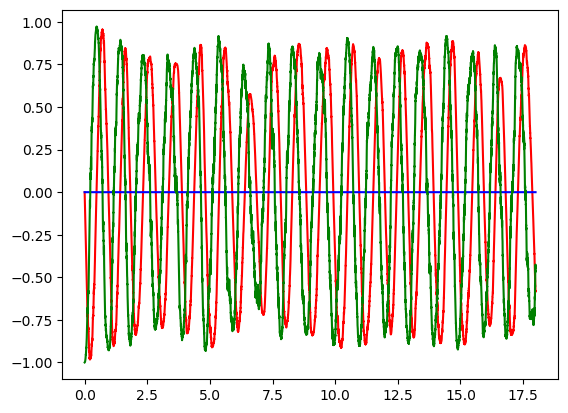

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1593cba90>

In [16]:
Random.seed!(1)
dt = 1e-3
tstep = [range(T[1], T[2], step=dt);]
tt, ρs = stochastic.master(tstep, ρ0, H0, J, C; dt=dt); # having trouble getting master_dynamic to work for H(t) comparison
evs = expects.(ρs)
evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evs[:,1], "r")
plt.plot(tt, evs[:,2], "b")
plt.plot(tt, evs[:,3], "g")

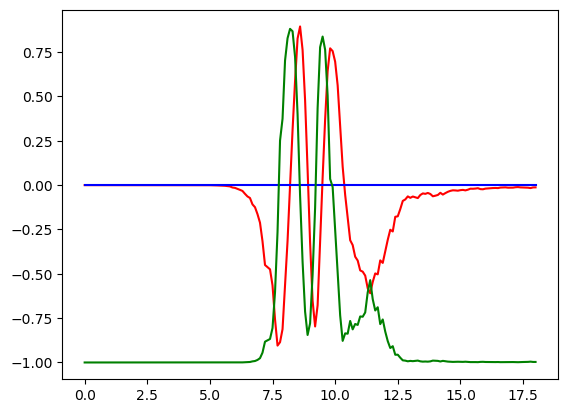

  0.135507 seconds (153.86 k allocations: 8.154 MiB)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x159a7b950>

In [17]:
Random.seed!(1)
dt0 = 1e-1
tt0, ρs0, dy = @time rouchon(T, ρ0, H, J, C; dt=dt0);
evs0 = expects.(ρs0)
evs0 = [evs0[n][ax] for n in 1:length(tt0), ax in 1:3]
plt.plot(tt0, evs0[:,1], "r")
plt.plot(tt0, evs0[:,2], "b")
plt.plot(tt0, evs0[:,3], "g")

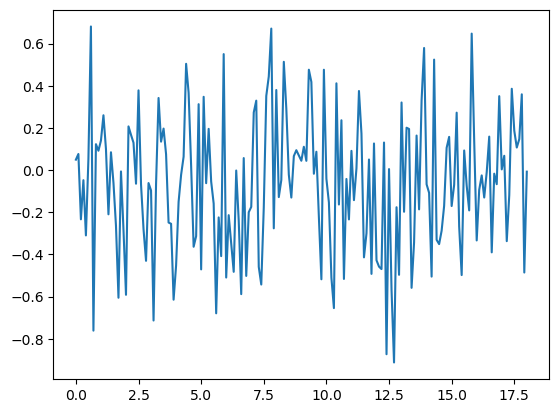

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15832fd50>

In [18]:
plt.plot(tt0, dy[1])

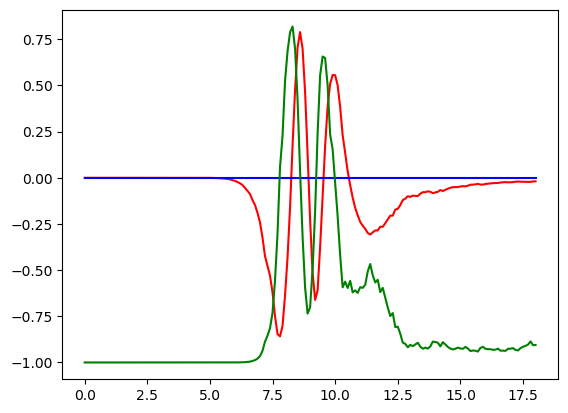

  5.762531 seconds (10.56 M allocations: 574.801 MiB, 4.55% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x159b9c910>

In [19]:
Random.seed!(1)
dt1 = dt0
tt1, ρs1, dy1 = @time bayesian(T, ρ0, H, J, C; dt=dt1);
evs1 = expects.(ρs1)
evs1 = [evs1[n][ax] for n in 1:length(tt1), ax in 1:3]
plt.plot(tt1, evs1[:,1], "r")
plt.plot(tt1, evs1[:,2], "b")
plt.plot(tt1, evs1[:,3], "g")

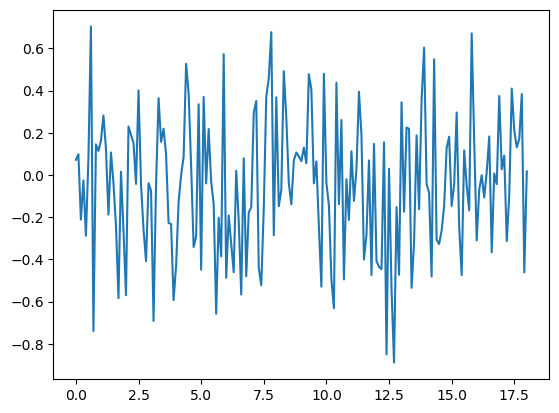

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x159af8510>

In [20]:
plt.plot(tt1, [dy[1]*dt1 for dy in dy1])

## Bayesian Test

In [109]:
# Parameters
n = 150 # ensemble size
Ω  = 2π # Rabi frequency
τ = 3.0 # Measurement collapse timescale
Γ = 1/(2τ) # Measurement dephasing rate
T = (0.0, 6τ) # Time duration of simulation
η = 0.3

# Basis
q = SpinBasis(1//2)

# Operators
σx = sigmax(q)
σy = sigmay(q)
σz = sigmaz(q)
id = identityoperator(q)

# Helper
expects = ρ -> collect(real(expect(ρ, s)) for s in [σx,σy,σz]) # ρ -> [<x>,<y>,<z>]
ispositive = ρ -> begin
  mineig = eigmin(real(ρ))
  if mineig > 0 || abs(mineig) < 1e-10
      return true
  else 
      return false
  end
end

F(ρ,σ) = norm(tr(sqrt(sqrt(σ.data)*ρ.data*sqrt(σ.data))))^2
average(ρt) = sum(ρt, dims=1)'/size(ρt)[1]

average (generic function with 1 method)

In [45]:
Random.seed!(1)

dt = 1e-4
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt1, ρt1 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt1, ρct1 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  2.950523 seconds (32.76 M allocations: 1.848 GiB, 27.84% gc time)
  3.062427 seconds (32.76 M allocations: 1.848 GiB, 27.38% gc time)


In [46]:
Random.seed!(1)

dt = 1e-3
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt2, ρt2 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt2, ρct2 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  0.295652 seconds (3.27 M allocations: 189.440 MiB)
  0.432231 seconds (3.27 M allocations: 189.440 MiB, 44.74% gc time)


In [59]:
Random.seed!(1)

dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

tt3, ρt3 = @time rouchon(T, ρ0, H0, [J0], [C0]; dt=dt)
tt3, ρct3 = @time rouchon(T, u, H0, [J0], [C0]; dt=dt);

  0.017394 seconds (325.30 k allocations: 18.903 MiB)
  0.130657 seconds (325.30 k allocations: 18.903 MiB, 79.19% gc time)


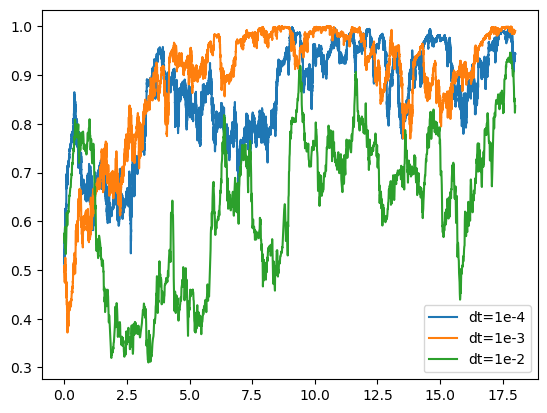

PyObject <matplotlib.legend.Legend object at 0x14a695950>

In [63]:
plt.plot(tt1, F.(ρt1, ρct1), label="dt=1e-4")
plt.plot(tt2, F.(ρt2, ρct2), label="dt=1e-3")
plt.plot(tt3, F.(ρt3, ρct3), label="dt=1e-2")
plt.legend()

# Ensemble Average Fidelity Comparisons

In [307]:
@everywhere begin
dt = 1e-3
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

tt1, ρt1 = @time ensemble(rouchon, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
tt1, ρct1 = @time ensemble(rouchon, T, u, H0, [J0], [C0]; dt=dt, N=500);

127.159338 seconds (1.64 G allocations: 92.567 GiB, 30.90% gc time)
125.783316 seconds (1.64 G allocations: 92.567 GiB, 32.37% gc time)


In [308]:
@everywhere begin
dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

tt3, ρt3 = @time ensemble(rouchon, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
tt3, ρct3 = @time ensemble(rouchon, T, u, H0, [J0], [C0]; dt=dt, N=500);

 12.526062 seconds (162.65 M allocations: 9.237 GiB, 35.84% gc time)
 15.207203 seconds (162.65 M allocations: 9.237 GiB, 32.25% gc time)


In [309]:
@everywhere begin
dt = 1e-2
atol = 1e-6

ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2
end

btt2, bρt2 = @time ensemble(bayesian, T, ρ0, H0, [J0], [C0]; dt=dt, N=500)
btt2, bρct2 = @time ensemble(bayesian, T, u, H0, [J0], [C0]; dt=dt, N=500);

MethodError: MethodError: no method matching bayesian(::Tuple{Int64,Float64}, ::Operator{SpinBasis{1//2,Int64},SpinBasis{1//2,Int64},Array{Complex{Float64},2}}, ::Operator{SpinBasis{1//2,Int64},SpinBasis{1//2,Int64},SparseArrays.SparseMatrixCSC{Complex{Float64},Int64}}, ::Array{Operator{SpinBasis{1//2,Int64},SpinBasis{1//2,Int64},SparseArrays.SparseMatrixCSC{Complex{Float64},Int64}},1}, ::Array{Operator{SpinBasis{1//2,Int64},SpinBasis{1//2,Int64},SparseArrays.SparseMatrixCSC{Complex{Float64},Int64}},1}; fn=QuantumCircuits.var"#89#94"(), dt=0.01, dy=Any[])
Closest candidates are:
  bayesian(::Tuple, ::Any, ::Any, ::Array, ::Array; fn, dt, readout) at /Users/luke/Dropbox/Work/Summer 2020/QuantumCircuits/src/QuantumCircuits.jl:108 got unsupported keyword argument "dy"

In [310]:
# plt.plot(tt1, expect.(average(ρt1), [σx for i in 1:length(tt1)]))
# plt.plot(tt2, expect.(average(ρt2), [σx for i in 1:length(tt2)]))
# plt.plot(btt1, expect.(average(bρt1), [σx for i in 1:length(btt1)]))
# plt.plot(btt2, expect.(average(bρt2), [σx for i in 1:length(btt2)]))

In [311]:
plt.plot(tt3, log.(1 .- F.(average(ρt3), average(ρct3))), label="rouchon: dt=1e-2")
plt.plot(tt1, log.(1 .- F.(average(ρt1), average(ρct1))), label="rouchon: dt=1e-3")
# plt.plot(tt2, log.(1 .- F.(average(ρt2), average(ρct2))), label="rouchon: dt=1e-4")
plt.plot(btt2, log.(1 .- F.(average(bρt2), average(bρct2))), label="bayesian: dt=1e-2")
# plt.plot(btt1, log.(1 .- F.(average(bρt1), average(bρct1))), label="bayesian: dt=1e-3")
plt.xlabel("Time")
plt.ylabel("Log(1-Fidelity)")
plt.legend()

UndefVarError: UndefVarError: bρt2 not defined

# Coarse Graining

In [3]:
function coarsegrain(fine=[]; n=2)
    coarse = []
    for i in 1:length(fine)
        if i < n
            push!(coarse, mean(fine[1:i]))
        else
            push!(coarse, mean(fine[i-(n-1):i]))
        end
    end
    coarse
end

function select(a=[]; n=2)
    a[filter(x -> x%n==1, eachindex(a))]
end

select (generic function with 2 methods)

## No Unitary Evolution

In absence of unitary evolution, Bayesian update should be $dt$ invariant.

In [92]:
dt = 1e-2
ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

η = 1
J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = 0σz

T = (0,45)

scale=10

Random.seed!(1)
tt, ρt, dy = @time bayesian(T, ρ0, H0, [J0], [C0]; dt=dt/scale);
tt, ρtu, dyu = @time bayesian(T, u, H0, [J0], [C0]; dt=dt/scale, readout=dy);

ro = coarsegrain(dy[1]; n=scale)
ros = select(ro; n=scale)
tt2, ρt2, dy2 = @time bayesian(T, ρ0, H0, [J0], [C0]; dt=dt, readout=[ros]);
tt2, ρtu2, dyu2 = @time bayesian(T, u, H0, [J0], [C0]; dt=dt, readout=dy2);

  2.104259 seconds (15.58 M allocations: 1.230 GiB, 24.44% gc time)
 18.175057 seconds (13.95 M allocations: 16.243 GiB, 10.41% gc time)
  0.332070 seconds (1.51 M allocations: 277.842 MiB)
  0.364396 seconds (1.40 M allocations: 272.776 MiB, 23.25% gc time)


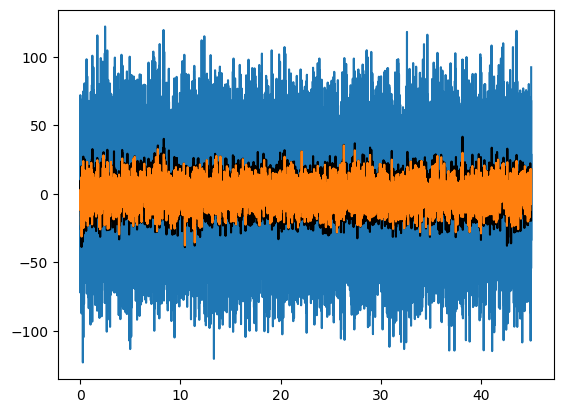

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x246dac810>

In [93]:
plt.plot(tt, dy[1])
plt.plot(tt, coarsegrain(dy[1], n=scale), "black")
plt.plot(select(tt, n=scale), select(coarsegrain(dy[1], n=scale), n=scale))

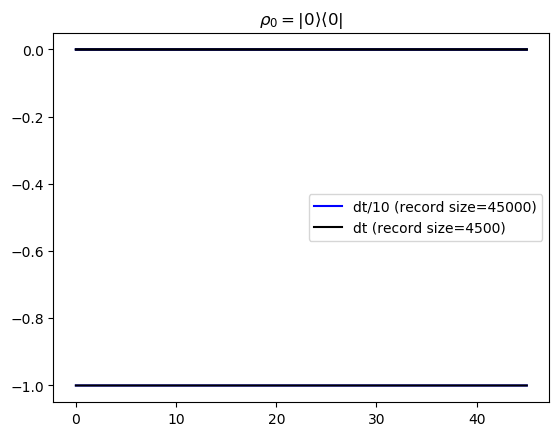

PyObject <matplotlib.legend.Legend object at 0x253cd6f10>

In [94]:
evs = expects.(ρt)
evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evs[:,3], "blue")
plt.plot(tt, evs[:,2], "blue")
plt.plot(tt, evs[:,1], "blue", label="dt/$scale (record size=$(length(tt)-1))")

evs2 = expects.(ρt2)
evs2 = [evs2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evs2[:,3], "black")
plt.plot(tt2, evs2[:,2], "black")
plt.plot(tt2, evs2[:,1], "black", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = |0\rightangle \leftangle 0|")
plt.legend()

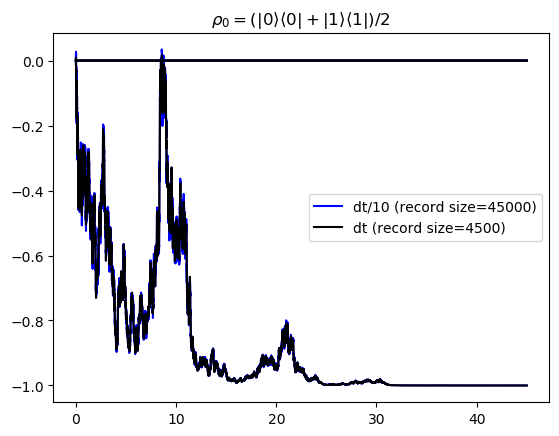

PyObject <matplotlib.legend.Legend object at 0x25513af50>

In [95]:
evsu = expects.(ρtu)
evsu = [evsu[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evsu[:,3], "blue")
plt.plot(tt, evsu[:,2], "blue")
plt.plot(tt, evsu[:,1], "blue", label="dt/$scale (record size=$(length(tt)-1))")

evsu2 = expects.(ρtu2)
evsu2 = [evsu2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evsu2[:,3], "black")
plt.plot(tt2, evsu2[:,2], "black")
plt.plot(tt2, evsu2[:,1], "black", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = (|0\rightangle \leftangle 0| + |1\rightangle \leftangle 1|)/2")
plt.legend()

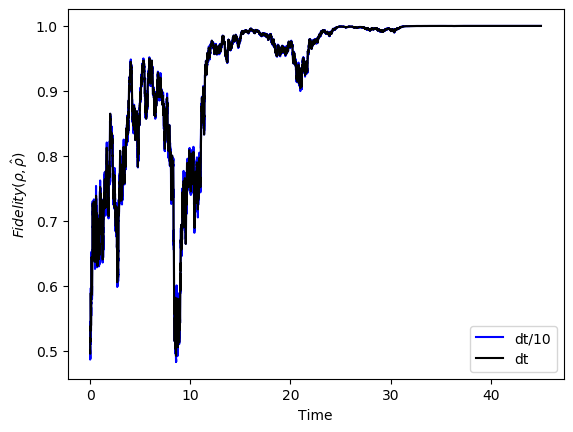

PyObject <matplotlib.legend.Legend object at 0x22fdecf10>

In [96]:
plt.plot(tt, F.(ρt, ρtu), "blue", label="dt/$scale")
plt.plot(tt2, F.(ρt2, ρtu2), "black", label="dt")
plt.xlabel("Time")
plt.ylabel(L"Fidelity(\rho,\hat\rho)")
plt.legend()

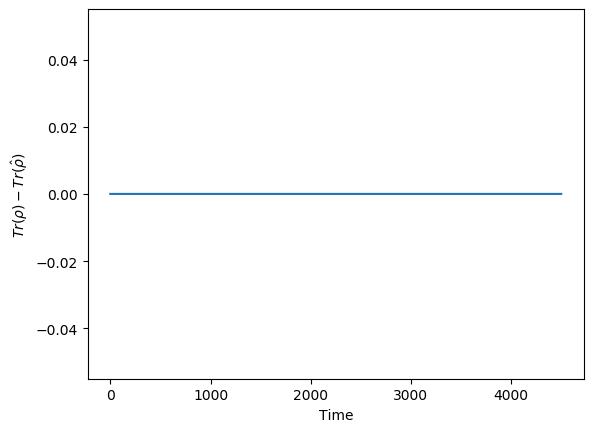

PyObject Text(30.236111111111114, 0.5, '$Tr(\\rho)-Tr(\\hat\\rho)$')

In [97]:
plt.plot(round.(tr.(select(ρt; n=scale) .- ρt2), digits=8))
plt.xlabel("Time")
plt.ylabel(L"Tr(\rho)-Tr(\hat\rho)")

## Unitary Evolution

In [71]:
dt = 1e-2
ρ0 = dm(spindown(q))
ρ1 = dm(spinup(q))
u = (ρ0 + ρ1)/2

J0 = √Γ*σz
C0 = √(Γ*η)*σz
H0 = Ω*σy/2

T = (0, 6τ)

scale=100

Random.seed!(1)
tt, ρt, dy = @time bayesian(T, ρ0, H, [J0], [C0]; dt=dt/scale);
tt, ρtu, dyu = @time bayesian(T, u, H, [J0], [C0]; dt=dt/scale, readout=dy);

ro = coarsegrain(dy[1]; n=scale)
ros = select(ro; n=scale)
tt2, ρt2, dy2 = @time bayesian(T, ρ0, H, [J0], [C0]; dt=dt, readout=[ros]);
tt2, ρtu2, dyu2 = @time bayesian(T, u, H, [J0], [C0]; dt=dt, readout=dy2);

 10.813015 seconds (64.72 M allocations: 4.833 GiB, 16.30% gc time)
427.480866 seconds (58.50 M allocations: 245.947 GiB, 9.24% gc time)
  0.284946 seconds (584.64 k allocations: 71.554 MiB)
  0.229976 seconds (584.64 k allocations: 71.554 MiB)


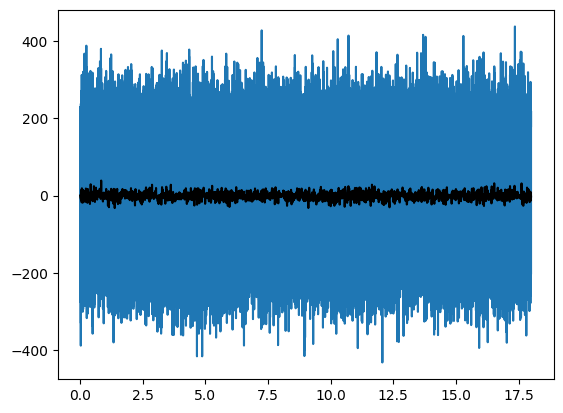

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x22f5a6d50>

In [72]:
plt.plot(tt, dy[1])
plt.plot(tt2, dy2[1], "black")

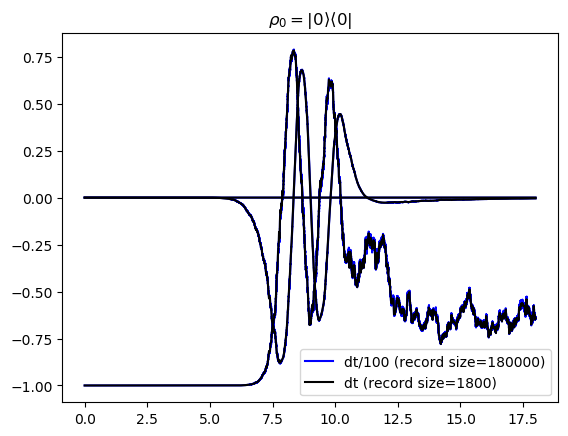

PyObject <matplotlib.legend.Legend object at 0x22fdf7310>

In [73]:
evs = expects.(ρt)
evs = [evs[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evs[:,3], "blue")
plt.plot(tt, evs[:,2], "blue")
plt.plot(tt, evs[:,1], "blue", label="dt/$scale (record size=$(length(tt)-1))")

evs2 = expects.(ρt2)
evs2 = [evs2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evs2[:,3], "black")
plt.plot(tt2, evs2[:,2], "black")
plt.plot(tt2, evs2[:,1], "black", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = |0\rightangle \leftangle 0|")
plt.legend()

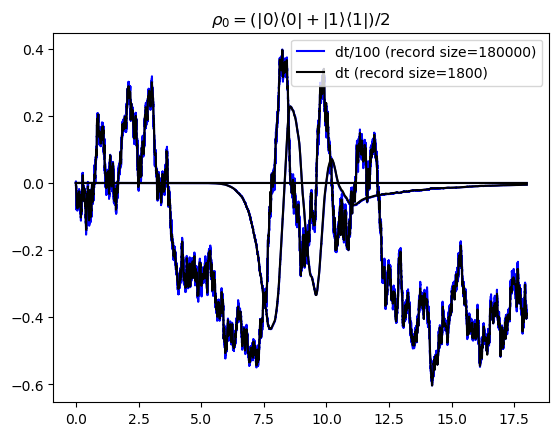

PyObject <matplotlib.legend.Legend object at 0x22f495d10>

In [74]:
evsu = expects.(ρtu)
evsu = [evsu[n][ax] for n in 1:length(tt), ax in 1:3]
plt.plot(tt, evsu[:,3], "blue")
plt.plot(tt, evsu[:,2], "blue")
plt.plot(tt, evsu[:,1], "blue", label="dt/$scale (record size=$(length(tt)-1))")

evsu2 = expects.(ρtu2)
evsu2 = [evsu2[n][ax] for n in 1:length(tt2), ax in 1:3]
plt.plot(tt2, evsu2[:,3], "black")
plt.plot(tt2, evsu2[:,2], "black")
plt.plot(tt2, evsu2[:,1], "black", label="dt (record size=$(length(tt2)-1))")

plt.title(L"ρ_0 = (|0\rightangle \leftangle 0| + |1\rightangle \leftangle 1|)/2")
plt.legend()

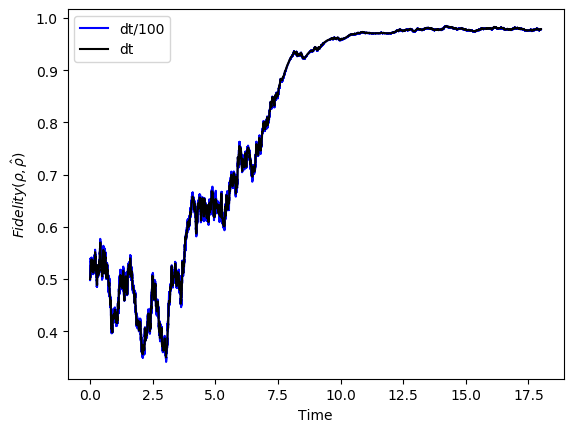

PyObject <matplotlib.legend.Legend object at 0x24aaa7f10>

In [75]:
plt.plot(tt, F.(ρt, ρtu), "blue", label="dt/$scale")
plt.plot(tt2, F.(ρt2, ρtu2), "black", label="dt")
plt.xlabel("Time")
plt.ylabel(L"Fidelity(\rho,\hat\rho)")
plt.legend()

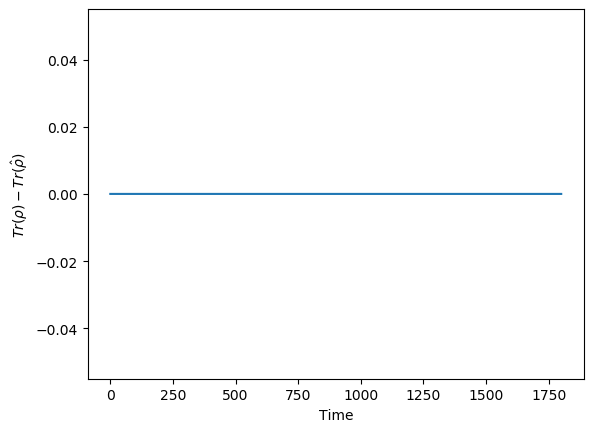

PyObject Text(30.236111111111114, 0.5, '$Tr(\\rho)-Tr(\\hat\\rho)$')

In [80]:
plt.plot(round.(tr.(select(ρt; n=scale) .- ρt2), digits=8))
plt.xlabel("Time")
plt.ylabel(L"Tr(\rho)-Tr(\hat\rho)")